In [1]:
var openDigger = require('../src/open_digger');

# Notebook 手册

该 Notebook 是一个展示如何使用 OpenDigger 进行开源数据分析的示例文档。

## 函数组

OpenDigger 中包含了很多组用于数据分析和展示的函数组，例如 `render`, `label`, `quick`, `index`, `metric`, `relation`, `driver`。

### Render

由于 OpenDigger 使用 JupyterLab 进行数据分析，我们提供了标准的 [`plotyly`](https://plotly.com/javascript/) 接口来绘制各类图形。

可通过 `openDigger.render.plotly(data, config)` 函数使用 plotly 来绘制图形。

可直接使用 Node.js 内置的 `console.table` 函数进行表格绘制。

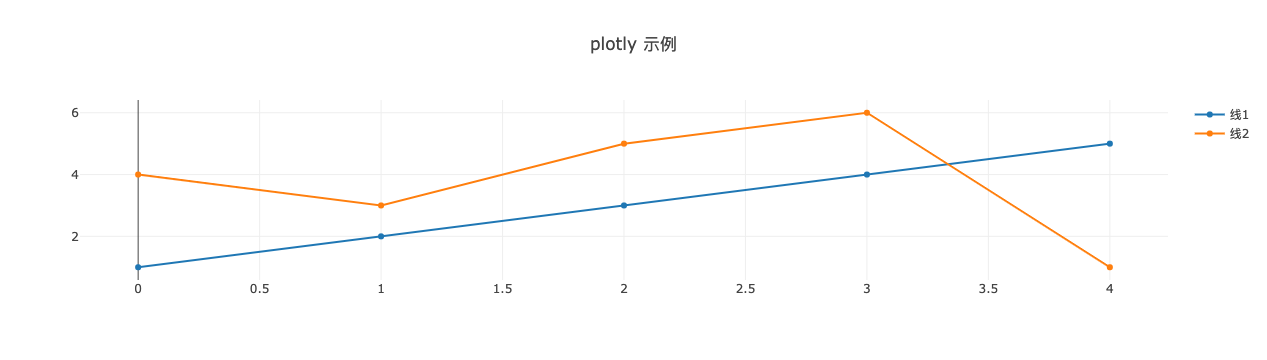

┌─────────┬──────────┬───────┐
│ (index) │   name   │ score │
├─────────┼──────────┼───────┤
│    0    │  '李雷'  │  2.4  │
│    1    │ '韩梅梅' │  3.2  │
└─────────┴──────────┴───────┘


In [2]:
openDigger.render.plotly([{y: [1,2,3,4,5],name: '线1'}, {y: [4,3,5,6,1],name: '线2'}], {title: 'plotly 示例'});
console.table([{name: '李雷', score:2.4}, {name: '韩梅梅',score: 3.2}]);

### Label

OpenDigger 中提供了大量的仓库标签数据，例如公司、基金会、中国项目等。

使用 `openDigger.label.getLabelData()` 获取到所有的标签信息，使用 `openDigger.label.getGitHubData(typeOrIds: string[])` 获取具有特定标签的 GitHub 数据。

`openDigger.label.getLabelData()` 会返回如下的结构的一个数组：

``` javascript
{
    identifier: string;     // 标签的唯一标识，如：companies/alibaba 或 :foundations/apache
    type: string;           // 标签类型信息，如：Company 或 Foundation
    name: string;           // 标签的展示信息，如：Alibaba 或 Apache Software Foundation
    githubRepos: number[];  // 该标签下的所有 GitHub 仓库 ID
    githubOrgs: number[];   // 该标签下的所有 GitHub 组织 ID
    githubUsers: number[];  // 该标签下的所有 GitHub 用户 ID
}
```

`openDigger.label.getGitHubData(typeOrIds: string[])` 函数接受一组标签标识或标签类型，并返回所有具有任意标签标识或标签类型的 GitHub 数据。

In [3]:
var labelData = openDigger.label.getLabelData();
console.log(`OpenDigger 一共包含 ${labelData.length} 个标签标识与 ${new Set(labelData.map(l => l.type)).size} 个标签类型。`);

OpenDigger 一共包含 226 个标签标识与 9 个标签类型。


In [4]:
var data = openDigger.label.getGitHubData(['Foundation', 'Company']);
console.log(`OpenDigger 的公司和基金会标签下一共包含 ${data.githubRepos.length} 个仓库和 ${data.githubOrgs.length} 个组织。`);

OpenDigger 的公司和基金会标签下一共包含 154 个仓库和 331 个组织。


### Index

OpenDigger 提供了一组指数实现，用于快速进行数据的分析。

#### 活跃度指数

活跃度指数是由 X-lab 开发的一个基本指数，活跃度指数使用了 GitHub 事件日志中的 `IssueCommentEvent`、 `IssuesEvent`、 `PullRequestEvent` 和 `PullRequestReviewCommentEvent` 事件并进行加权求和。

可使用 `openDigger.index.activity.getRepoActivity(config)` 函数获取特定项目的活跃度指数。

`config` 的配置结构如下：

``` javascript
{
    labelUnion?: string[];                       // 获取包含其中任一标签的所有仓库
    labelIntersect?: string[];                   // 获取包含其中所有标签的所有仓库
    repoIds?: number[];                          // 特定的仓库 ID 数组
    repoNames?: string[];                        // 特定的仓库名数组
    orgIds?: number[];                           // 特定的组织 ID 数组
    orgNames?: string[];                         // 特定的组织名数组
    userIds?: number[];                          // 特定的用户 ID 数组，用于用户类查询
    userLogins?: string[];                       // 特定的用户名数组，用于用户类查询
    startYear?: number = 2015;                   // 查询数据的起始年份，默认为：2015
    startMonth?: number = 1;                     // 查询数据的起始月份，默认为：1
    endYear?: number = current_year;             // 查询数据的结束年份，默认为：当前年份
    endMonth?: number = last_month;              // 查询数据的结束月份，默认为：当前月份的上个月
    order?: 'DESC' | 'ASC';                      // 返回数据的排序方式：DESC 或 ASC，默认：不排序
    limit?: number = 10;                         // 返回数据的数量，默认为：10
    limitOption?: 'each' | 'all' = 'all';        // 截取数据时对每个时间区间截断或对总体数据截断，默认为：总体截断
    percision?: number = 2;                      // 返回浮点类数据的小数点后精度，默认为：2
    groupBy?: 'org' | string;                    // 仓库数据的聚合方式，org 或任意标签类型，默认为空，则按仓库返回
    groupTimeRange?: 'month' | 'season' | 'year';// 指数或度量项在时间上的聚合方式，月度、季度或年度，默认全部聚合
}
```

> ***该配置将用于所有指数和度量项的查询。***

通过修改配置参数理论上可以满足各类的数据分析需求。

- getRepoActivity

该函数会根据配置参数返回仓库的活跃度。

下面这个示例展示了 2015 到 2021 年之间所有中国项目按照公司聚合的年度活跃度数据，并使用 plotly 绘制。

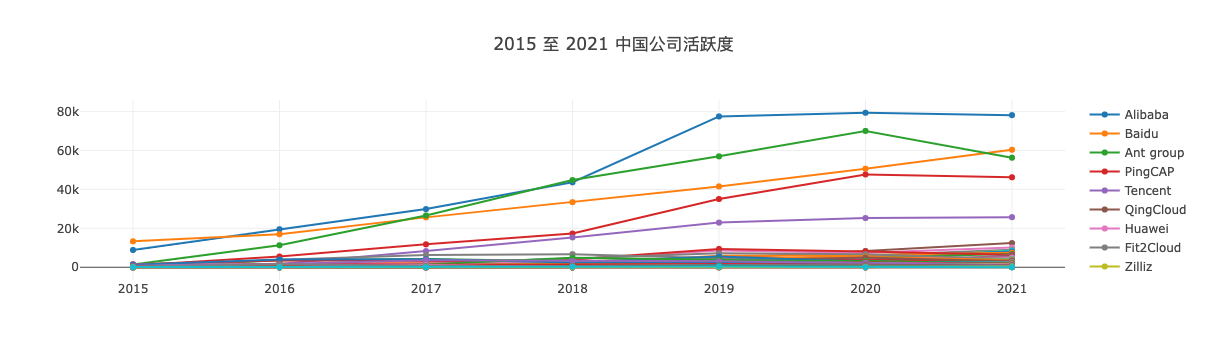

In [5]:
var startYear = 2015, startMonth = 1, endYear = 2021, endMonth = 12, x = [];
for (let y = startYear; y <= endYear; y++) x.push(`${y}`);
openDigger.index.activity.getRepoActivity({labelIntersect: ['Company', ':regions/China'], startYear, startMonth, endYear, endMonth, groupBy: 'Company', groupTimeRange: 'year', limit: -1, order: 'DESC' }).then(data => {
    openDigger.render.plotly(data.map(row => {
        return { x, y: row.activity, mode: 'scatter', name: row.name };
    }), {title: `${startYear} 至 ${endYear} 中国公司活跃度`, xaxis: {type: 'category'}});
});

- getUserActivity

该函数会根据配置参数返回用户的活跃度。

下面这个示例展示了 2015 到 2021 年之间 k8s-ci-robot 和 vscode-triage-bot 这两个账号年度活跃度变化趋势。

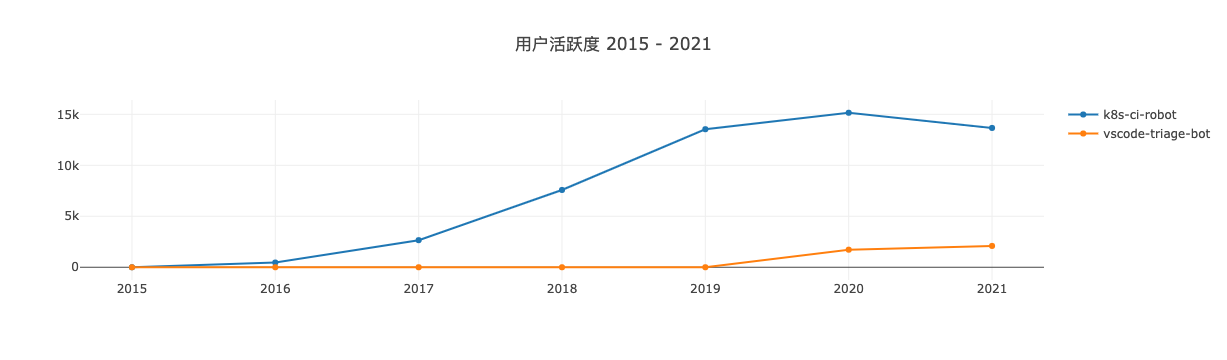

In [6]:
var startYear = 2015, startMonth = 1, endYear = 2021, endMonth = 12, x = [];
for (let y = startYear; y <= endYear; y++) x.push(`${y}`);
openDigger.index.activity.getUserActivity({userLogins: ['k8s-ci-robot', 'vscode-triage-bot'], startYear, startMonth, endYear, endMonth, groupTimeRange: 'year', order: 'DESC' }).then(data => {
    openDigger.render.plotly(data.map(row => {
        return { x, y: row.activity, mode: 'scatter', name: row.name };
    }), {title: `用户活跃度 ${startYear} - ${endYear}`, xaxis: {type: 'category'}});
});

#### 关注度指标

关注度指标是由 X-lab 团队开发的一个基本统计指标。该指标使用 GitHub 日志中的 `WatchEvent` 和 `ForkEvent`，此类事件可以表示仓库在一段时间内的被关注情况，但不会对仓库有实质性贡献。

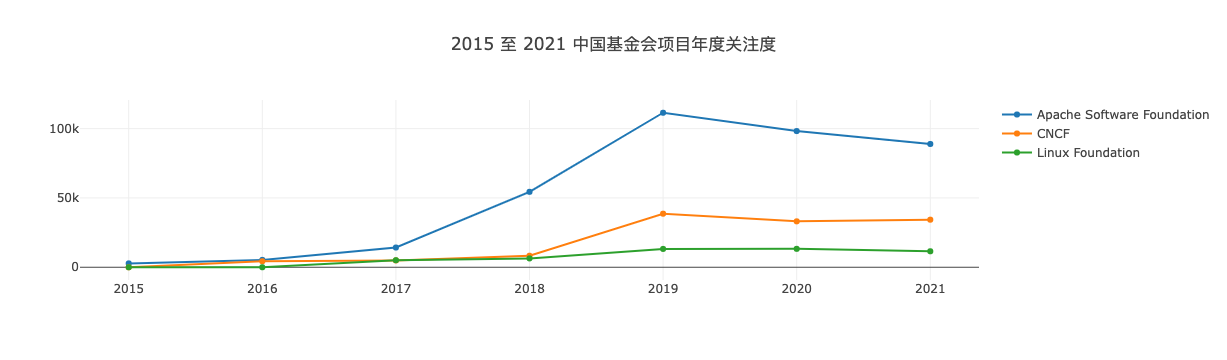

In [7]:
var startYear = 2015, startMonth = 1, endYear = 2021, endMonth = 12, x = [];
for (let y = startYear; y <= endYear; y++) x.push(`${y}`);
openDigger.index.attention.getAttention({labelIntersect: ['Foundation', ':regions/China'], startYear, startMonth, endYear, endMonth, groupBy: 'Foundation', groupTimeRange: 'year', limit: -1, order: 'DESC' }).then(data => {
    openDigger.render.plotly(data.map(row => {
        return { x, y: row.attention, mode: 'scatter', name: row.name };
    }), {title: `${startYear} 至 ${endYear} 中国基金会项目年度关注度`, xaxis: {type: 'category'}});
});

#### OpenRank

OpenRank 指数是由 X-lab 开发的一个图指标。OpenRank 使用活跃度为基础数据构建出 GitHub 全域的协作开发网络，以开发者和仓库为节点，活跃关系为边。

OpenRank 使用一种支持异质图的类 PageRank 算法—— HINRank 对全域的开发者和仓库进行同时排序，用以找到开源世界中重要的开发者和项目。

- getRepoOpenrank

该函数会根据配置参数返回仓库的 OpenRank 值。

下面这个示例展示了 2015 到 2021 年之间所有中国捐献到基金会的项目按照基金会聚合的年度 OpenRank 数据，并使用 plotly 绘制。

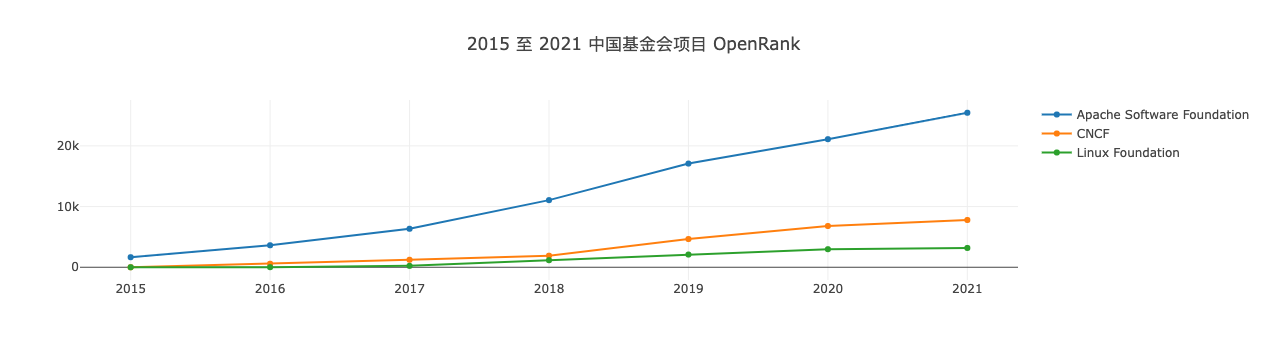

In [8]:
var startYear = 2015, startMonth = 1, endYear = 2021, endMonth = 12, x = [];
for (let y = startYear; y <= endYear; y++) x.push(`${y}`);
openDigger.index.openrank.getRepoOpenrank({labelIntersect: ['Foundation', ':regions/China'], startYear, startMonth, endYear, endMonth, groupBy: 'Foundation', groupTimeRange: 'year', limit: -1, order: 'DESC' }).then(data => {
    openDigger.render.plotly(data.map(row => {
        return { x, y: row.openrank, mode: 'scatter', name: row.name };
    }), {title: `${startYear} 至 ${endYear} 中国基金会项目 OpenRank`, xaxis: {type: 'category'}});
});

- getUserOpenrank

该函数会根据配置参数返回用户的 OpenRank 值。

下面这个示例展示了 2015 到 2021 年之间 k8s-ci-robot 和 vscode-triage-bot 这两个账号年度 OpenRank 值的变化趋势。

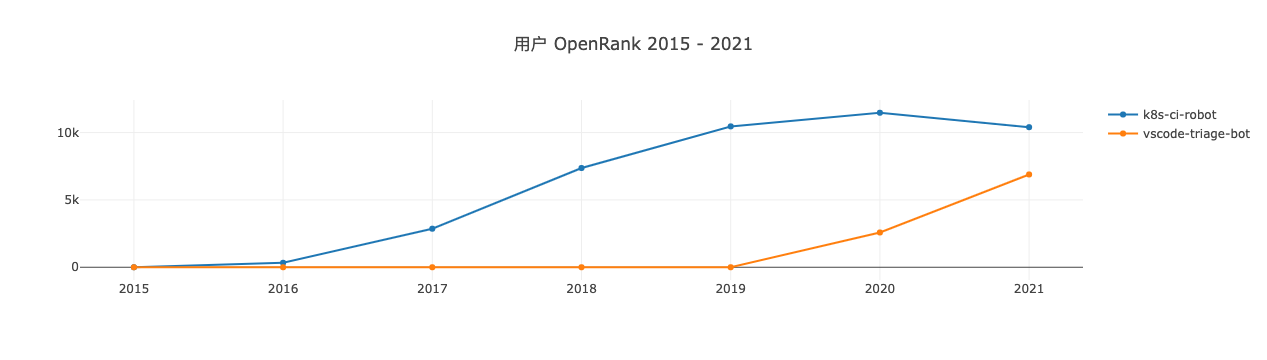

In [9]:
var startYear = 2015, startMonth = 1, endYear = 2021, endMonth = 12, x = [];
for (let y = startYear; y <= endYear; y++) x.push(`${y}`);
openDigger.index.openrank.getUserOpenrank({userLogins: ['k8s-ci-robot', 'vscode-triage-bot'], startYear, startMonth, endYear, endMonth, groupTimeRange: 'year', order: 'DESC'}).then(data => {
    openDigger.render.plotly(data.map(row => {
        return { x, y: row.openrank, mode: 'scatter', name: row.name };
    }), {title: `用户 OpenRank ${startYear} - ${endYear}`, xaxis: {type: 'category'}});
});

### Metric

OpenDigger 同时提供了一组度量项用于深入观察项目状态。

大部分度量项来自于 CHAOSS 社区。

#### Code Change Commits

Code Change Commits 是一个来自 CHAOSS 的指标，请参考 https://chaoss.community/metric-code-changes/。

Code Change Commits 包含如下的额外选项：

- messageFilter：用于根据 commit message 对 commit 进行筛选的正则表达式，如 '^feat:.\*' 或 '^(docs:|refactor:).\*'。默认值： null。

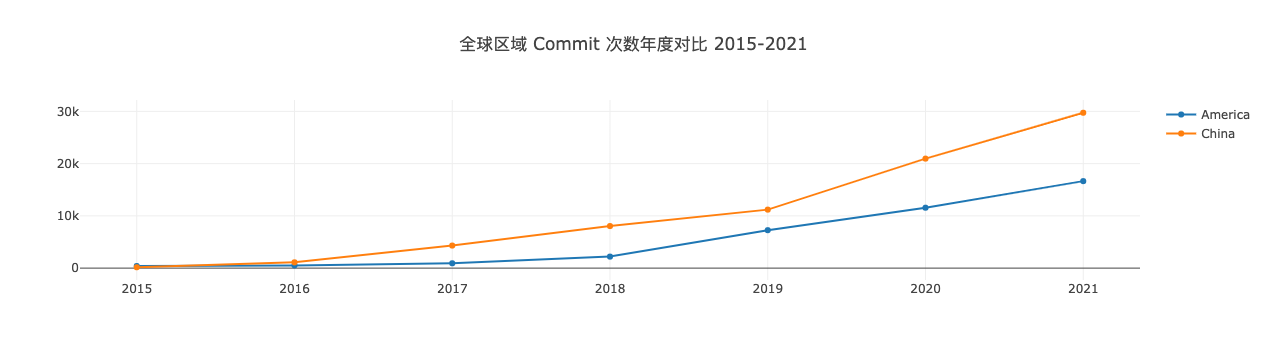

In [10]:
var startYear = 2015, startMonth = 1, endYear = 2021, endMonth = 12, x = [];
for (let y = startYear; y <= endYear; y++) x.push(`${y}`);
openDigger.metric.chaoss.codeChangeCommits({ labelIntersect: ['Region'], startYear, startMonth, endYear, endMonth, groupBy: 'Region', groupTimeRange: 'year', limit: -1, options: { messageFilter: '^feat:.*' } }).then(data => {
    openDigger.render.plotly(data.filter(row => row.name != 'Others').map(row => {
        return {
            x,
            y: row.count,
            mode: 'scatter',
            name: row.name
        };
    }), {title: `全球区域 Commit 次数年度对比 ${startYear}-${endYear}`, xaxis: {type: 'category'}});
});

#### Issues New

Issues new 是一个来自 CHAOSS 的指标，请参考 https://chaoss.community/metric-issues-new/ 。

公司 Microsoft 的 Issues New 度量的创建比例为 ["2.8%","8.6%","12%","13%","18%","24%","21%"]


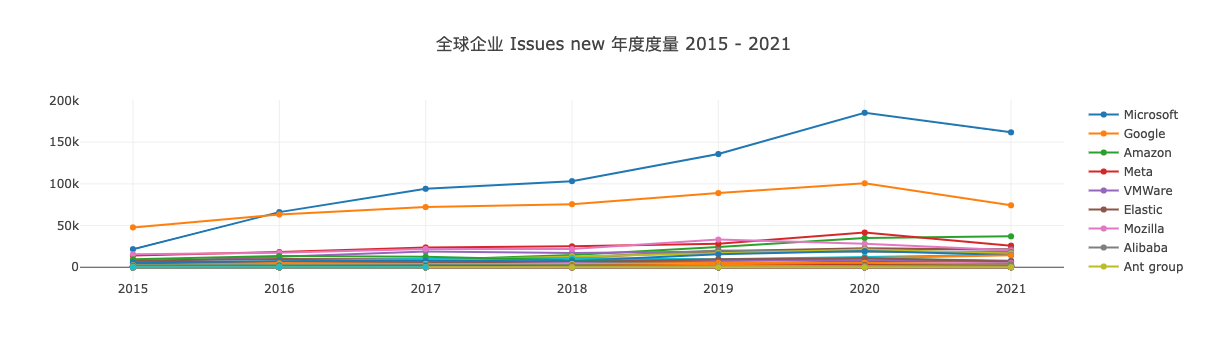

In [11]:
var startYear = 2015, startMonth = 1, endYear = 2021, endMonth = 12, x = [];
for (let y = startYear; y <= endYear; y++) x.push(`${y}`);
openDigger.metric.chaoss.issuesNew({ labelIntersect: ['Company'], startYear, startMonth, endYear, endMonth, groupBy: 'Company', groupTimeRange: 'year', limit: -1, order: 'DESC' }).then(data => {
    console.log(`公司 ${data[0].name} 的 Issues New 度量的创建比例为 ${JSON.stringify(data[0].ratio)}`);
    openDigger.render.plotly(data.filter(row => row.name != 'Others').map(row => {
        return {
            x,
            y: row.count,
            mode: 'scatter',
            name: row.name
        };
    }), {title: `全球企业 Issues new 年度度量 ${startYear} - ${endYear}`, xaxis: {type: 'category'}});
});

#### Issues Closed

Issues closed 是一个来自 CHAOSS 的指标，请参考 https://chaoss.community/metric-issues-closed/ 。

公司 Google 的 Issues Closed 度量的创建比例为 ["4.9%","4.7%","6.3%","7.7%","7.0%","11%","9.0%","9.8%","9.6%","10%","9.2%","11%"]


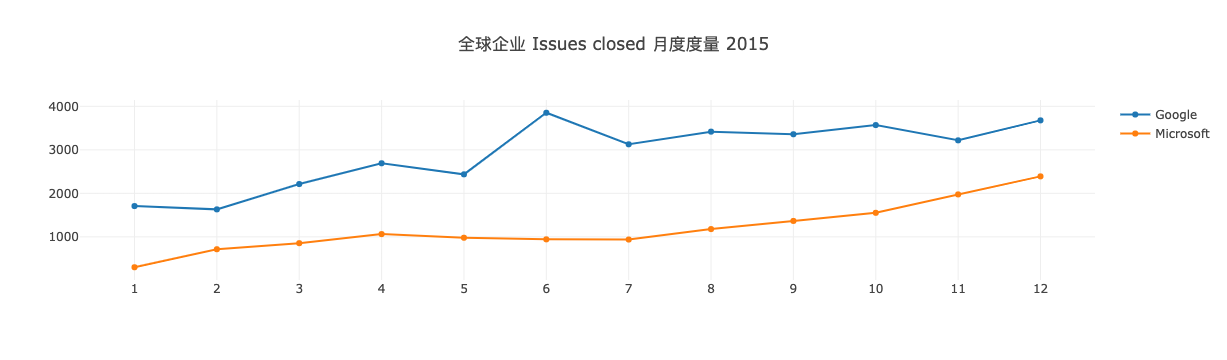

In [12]:
var startYear = 2015, startMonth = 1, endYear = 2015, endMonth = 12, x = [];
for (let y = startMonth; y <= endMonth; y++) x.push(`${y}`);
openDigger.metric.chaoss.issuesClosed({ labelIntersect: ['Company'], startYear, startMonth, endYear, endMonth, groupBy: 'Company', groupTimeRange: 'month', limit: 2, order: 'DESC' }).then(data => {
    console.log(`公司 ${data[0].name} 的 Issues Closed 度量的创建比例为 ${JSON.stringify(data[0].ratio)}`);
    openDigger.render.plotly(data.filter(row => row.name != 'Others').map(row => {
        return {
            x,
            y: row.count,
            mode: 'scatter',
            name: row.name
        };
    }), {title: `全球企业 Issues closed 月度度量 ${startYear}`, xaxis: {type: 'category'}});
});

#### Bus Factor

Bus factor（巴士系数） 是一个来自 CHAOSS 的指标，请参考 https://chaoss.community/metric-bus-factor/ 。

Bus factor 有如下一些额外选项

- withBot：`true` 或 `false`，是否包含 GitHub Apps 账号的贡献。默认：false。
- percentage：用于确定巴士系数开发者的贡献百分比。默认：0.5。
- by：使用何种方式进行计算，可选为 `commit`, `change request`, `activity`。默认：`activity`。

docker/hub-feedback 在 2015 第四季度的巴士系数开发者包括：pik(2), bhalothia(2), mato(3), hoangvuit(2), bcwalrus(3), zjyExcelsior(2), jrhouston(2), mghazizadeh(4), rafalwrzeszcz(2), dszryan(2), kentmw(2), eyal-rounds(2), damienleger(2), ppadial(2), Miguel-Fontes(2), inadarei(3), chrisvire(2), tdanielcox(2), MohammadsM(2), kristiehoward(4), shadowbq(3), dustinlacewell(2), lvlie(2), chriswayg(2), yoanisgil(2), timlinux(2), jmcejuela(2), Karm(2), audreyr(2), fgalan(2), brunzefb(2), wulfgarpro(2), buley(2), carlitux(3), shib1000(2), JeremJR(2), jfisbein(2), janeczku(4), joeldrapper(2), christoph-hipp(2), OrangeCrush(2), vdemeester(2), kadishmal(2), interactiveblueprints(2), urbanchaosmnky(2), strarsis(2), AdieSutcliffe(2), trinitronx(2), xbglowx(2), binhex(2), gerardo8a(2), eNcacz(2), adamkdean(2), teodorescuserban(3), dciccale(2), nathan-osman(2), gregkeys(2), GrahamDumpleton(2), Skeen(2), stepanic(2), bobrik(2), kellyp(2), dg-ratiodata(2), rippinrobr(2), hekaldama(2), sserrano44(2), madeleineth(2), bbore

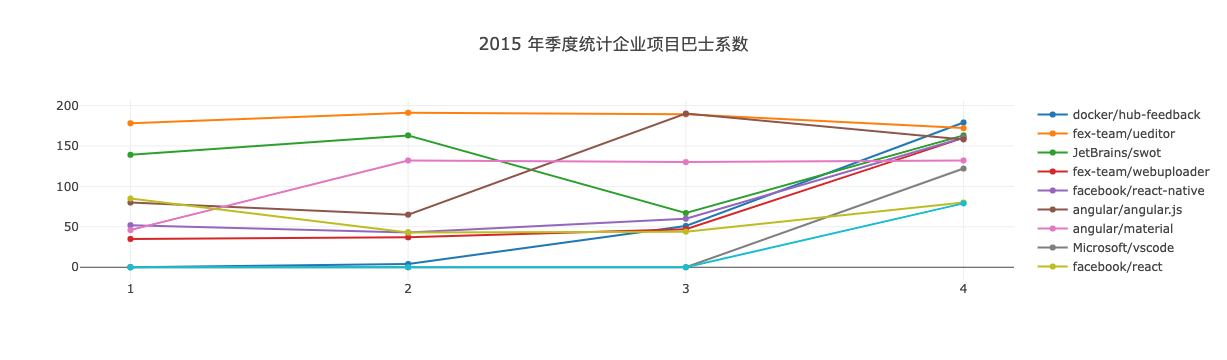

In [13]:
var startYear = 2015, startMonth = 1, endYear = 2015, endMonth = 12, x = [];
for (let y = 1; y <= 4; y++) x.push(`${y}`);
openDigger.metric.chaoss.busFactor({ labelIntersect: ['Company'], startYear, startMonth, endYear, endMonth, groupTimeRange: 'quarter', limit: 10, order: 'DESC', options: { withBot: true, percentage: 0.2 } }).then(data => {
    console.log(`${data[0].name} 在 2015 第四季度的巴士系数开发者包括：${data[0].detail[3].map(d => `${d[0]}(${d[1]})`).join(', ')}。贡献总数为 ${data[0].total_contributions[3]}。`);
    openDigger.render.plotly(data.filter(row => row.name != 'Others').map(row => {
        return {
            x,
            y: row.bus_factor,
            mode: 'scatter',
            name: row.name
        };
    }), {title: `2015 年季度统计企业项目巴士系数`, xaxis: {type: 'category'}});
});

或可以配置使用 commit 记录来计算。

mozilla/gecko-projects 在 2015 第四季度的巴士系数开发者包含：L. David Baron(13), Karl Tomlinson(47), Carsten "Tomcat" Book(35), Markus Stange(13), Tom Tromey(16), Gerald Squelart(50), Gijs Kruitbosch(27), Jan de Mooij(34), Christoph Kerschbaumer(20), Cameron McCormack(20), Nick Thomas(14), Gregor Wagner(14), Chris Peterson(12), Nick Alexander(13), Nicolas Silva(17), Tooru Fujisawa(13), B2G Bumper Bot(98), Valentin Gosu(15), Bob Clary(12), Wes Kocher(35), Kartikaya Gupta(15), Jim Chen(16), Rail Aliiev(52), Mark Banner(18), David Anderson(19), Nicholas Nethercote(41), Andrea Marchesini(15), Jean-Yves Avenard(14), Jon Coppeard(30), Xidorn Quan(22), Florian Quèze(39), JW Wang(41), Nick Fitzgerald(15), Ehsan Akhgari(25), Andreas Pehrson(20), Bevis Tseng(14), Ben Kelly(17)。贡献总数为 1838。


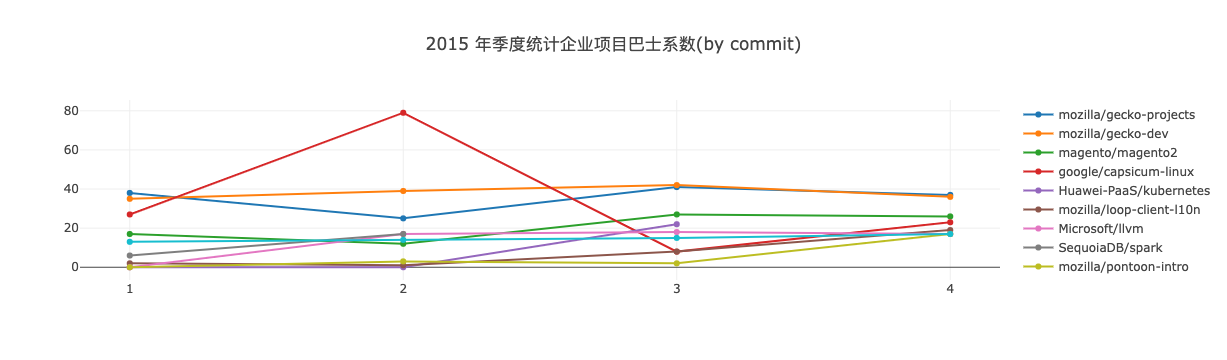

In [14]:
var startYear = 2015, startMonth = 1, endYear = 2015, endMonth = 12, x = [];
for (let y = 1; y <= 4; y++) x.push(`${y}`);
openDigger.metric.chaoss.busFactor({ labelIntersect: ['Company'], startYear, startMonth, endYear, endMonth, groupTimeRange: 'quarter', limit: 10, order: 'DESC', options: { by: 'commit' } }).then(data => {
    console.log(`${data[0].name} 在 2015 第四季度的巴士系数开发者包含：${data[0].detail[3].map(d => `${d[0]}(${d[1]})`).join(', ')}。贡献总数为 ${data[0].total_contributions[3]}。`);
    openDigger.render.plotly(data.filter(row => row.name != 'Others').map(row => {
        return {
            x,
            y: row.bus_factor,
            mode: 'scatter',
            name: row.name
        };
    }), {title: `2015 年季度统计企业项目巴士系数(by commit)`, xaxis: {type: 'category'}});
});

#### Change Requests Accepted

Change Requests Accepted 是一个来自 CHAOSS 的指标，请参考 https://chaoss.community/metric-change-requests-accepted/。

公司 Microsoft 的 Change Requests Accepted 度量的创建比例为 ["1.9%","5.1%","6.2%","7.9%","8.1%","7.9%","7.2%","9.0%","9.9%","12%","12%","12%"]


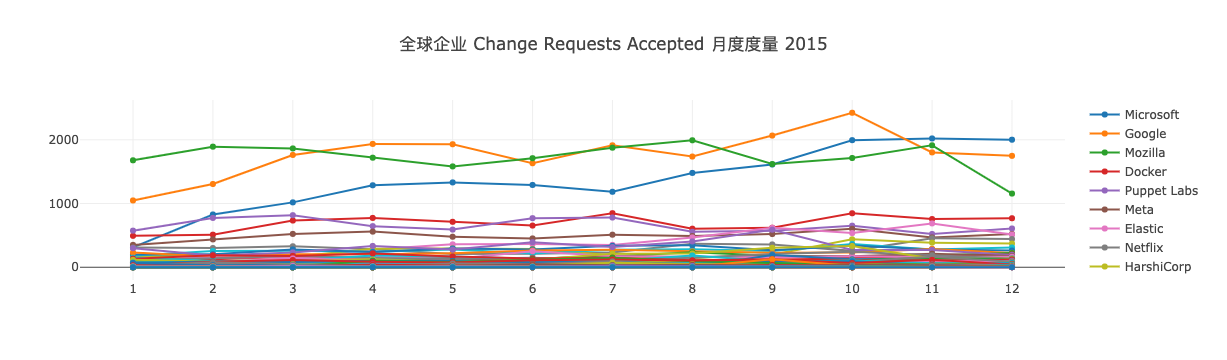

In [15]:
var startYear = 2015, startMonth = 1, endYear = 2015, endMonth = 12, x = [];
for (let y = startMonth; y <= endMonth; y++) x.push(`${y}`);
openDigger.metric.chaoss.changeRequestsAccepted({ labelIntersect: ['Company'], startYear, startMonth, endYear, endMonth, groupBy: 'Company', groupTimeRange: 'month', limit: -1, order: 'DESC' }).then(data => {
    console.log(`公司 ${data[0].name} 的 Change Requests Accepted 度量的创建比例为 ${JSON.stringify(data[0].ratio)}`);
    openDigger.render.plotly(data.filter(row => row.name != 'Others').map(row => {
        return {
            x,
            y: row.count,
            mode: 'scatter',
            name: row.name
        };
    }), {title: `全球企业 Change Requests Accepted 月度度量 ${startYear}`, xaxis: {type: 'category'}});
});

#### Change Requests Declined

Change Requests Declined 是一个来自 CHAOSS 的指标，请参考 https://chaoss.community/metric-change-requests-declined/。

公司 Google 的 Change Requests Declined 度量的创建比例为 ["5.1%","5.1%","5.9%","6.7%","5.9%","6.8%","8.3%","8.7%","11%","13%","11%","13%"]


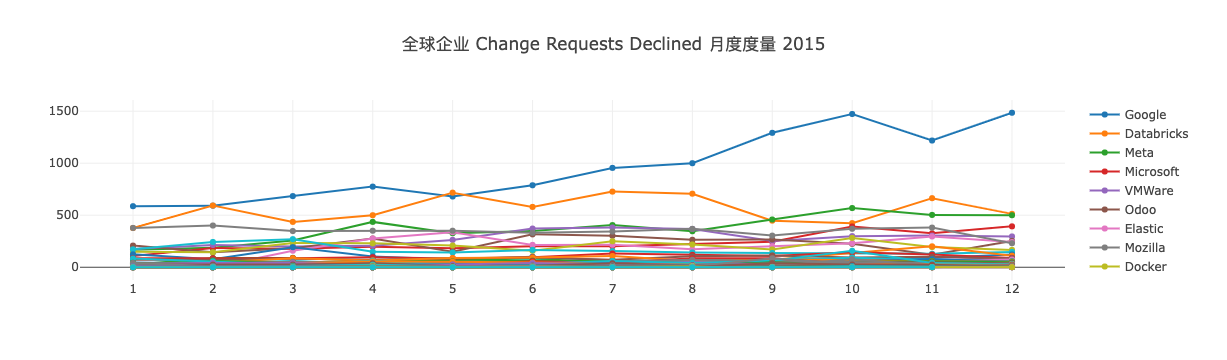

In [16]:
var startYear = 2015, startMonth = 1, endYear = 2015, endMonth = 12, x = [];
for (let y = startMonth; y <= endMonth; y++) x.push(`${y}`);
openDigger.metric.chaoss.changeRequestsDeclined({ labelIntersect: ['Company'], startYear, startMonth, endYear, endMonth, groupBy: 'Company', groupTimeRange: 'month', limit: -1, order: 'DESC' }).then(data => {
    console.log(`公司 ${data[0].name} 的 Change Requests Declined 度量的创建比例为 ${JSON.stringify(data[0].ratio)}`);
    openDigger.render.plotly(data.filter(row => row.name != 'Others').map(row => {
        return {
            x,
            y: row.count,
            mode: 'scatter',
            name: row.name
        };
    }), {title: `全球企业 Change Requests Declined 月度度量 ${startYear}`, xaxis: {type: 'category'}});
});

#### Change Requests Duration

Change Requests Duration 是一个来自 CHAOSS 的度量, 请参考 https://chaoss.community/metric-change-request-duration/.

Change Requests duration 度量有如下一些额外选项:

- by：`open` 或 `close`。使用 Issue 的开启或关闭时间作为统计方法。 默认值：`open`。
- type：`avg` 或 `median`。使用平均数或中位数用于计算的聚合方式。默认值：`avg`。
- unit：`week`、`day`、`hour` 或 `minute`。计算后的数值单位。默认值：`day`。

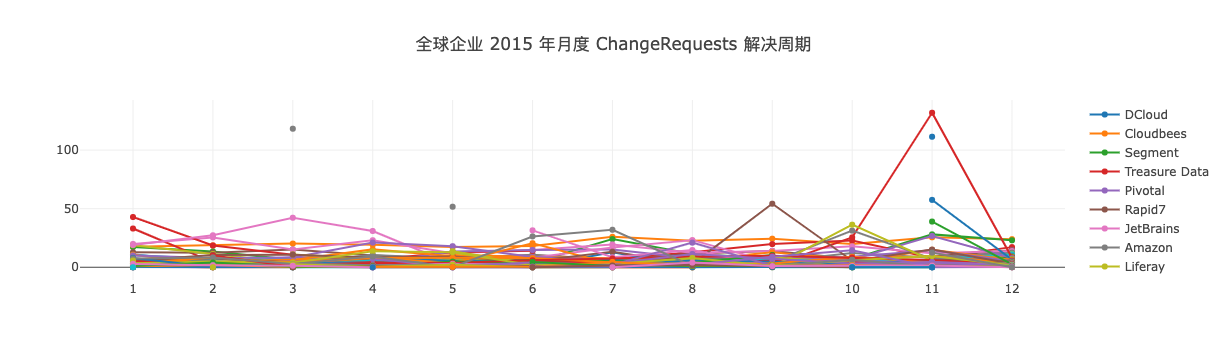

In [17]:
var startYear = 2015, startMonth = 1, endYear = 2015, endMonth = 12, x = [];
for (let y = startMonth; y <= endMonth; y++) x.push(`${y}`);
openDigger.metric.chaoss.chaossChangeRequestsDuration({
    labelIntersect: ['Company'], startYear, startMonth, endYear, endMonth, order: 'DESC', groupBy: 'Company', groupTimeRange: 'month', limit: -1,
    options: {by: 'close', type: 'avg', unit: 'day' } }).then(data => {
    openDigger.render.plotly(data.filter(row => row.name != 'Others').map(row => {
        return {
            x,
            y: row.resolution_duration,
            mode: 'scatter',
            name: row.name
        };
    }), {title: `全球企业 2015 年月度 ChangeRequests 解决周期`, xaxis: {type: 'category'}});
});

#### Issue Resolution Duration

Issue Resolution Duration 是一个来自 CHAOSS 的度量, 请参考 https://chaoss.community/metric-issue-resolution-duration/.

Issue resolution duration 度量有如下一些额外选项:

- by：`open` 或 `close`。使用 Issue 的开启或关闭时间作为统计方法。 默认值：`open`。
- type：`avg` 或 `median`。使用平均数或中位数用于计算的聚合方式。默认值：`avg`。
- unit：`week`、`day`、`hour` 或 `minute`。计算后的数值单位。默认值：`day`。

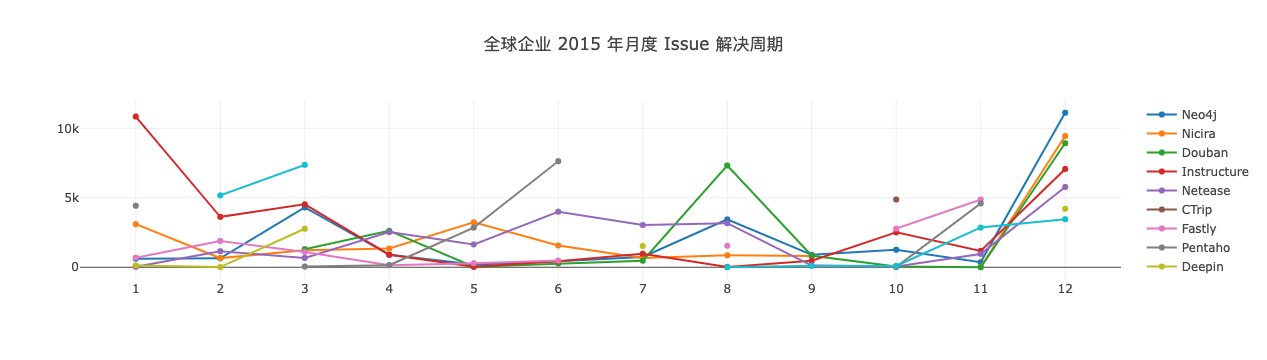

In [18]:
var startYear = 2015, startMonth = 1, endYear = 2015, endMonth = 12, x = [];
for (let y = startMonth; y <= endMonth; y++) x.push(`${y}`);
openDigger.metric.chaoss.chaossIssueResolutionDuration({
    labelIntersect: ['Company'], startYear, startMonth, endYear, endMonth, order: 'DESC', groupBy: 'Company', groupTimeRange: 'month', limit: 10,
    options: {by: 'close', type: 'avg', unit: 'hour' } }).then(data => {
    openDigger.render.plotly(data.filter(row => row.name != 'Others').map(row => {
        return {
            x,
            y: row.resolution_duration,
            mode: 'scatter',
            name: row.name
        };
    }), {title: `全球企业 2015 年月度 Issue 解决周期`, xaxis: {type: 'category'}});
});

#### Code Change Lines
Code Change Lines 是一个来自CHAOSS的度量, 请参考 https://chaoss.community/metric-code-changes-lines/

Code Change Lines 度量有如下额外选项:

- by: `add`or`remove`or`sum`。计算新增的代码行数或移除的代码行数或者总增删行数之和。默认值：`add`。

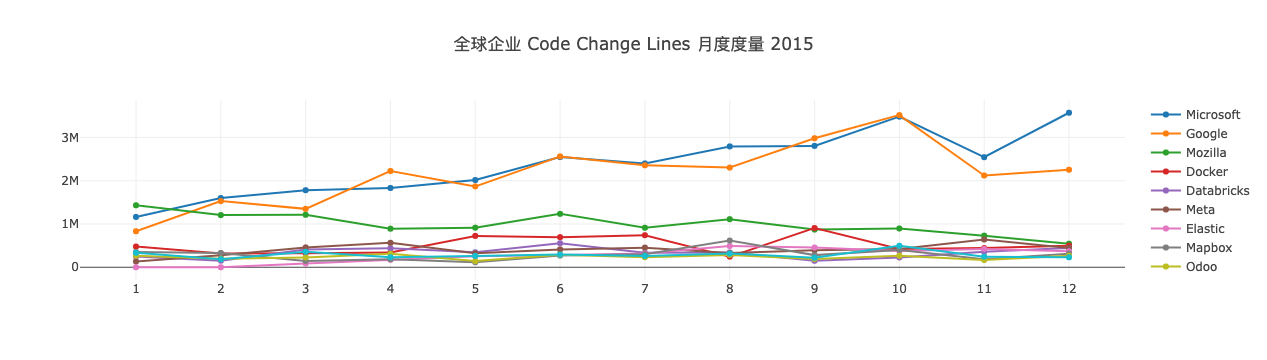

In [19]:
var startYear = 2015, startMonth = 1, endYear = 2015, endMonth = 12, x = [];
for (let y = startMonth; y <= endMonth; y++) x.push(`${y}`);
openDigger.metric.chaoss.chaossCodeChangeLines({
labelIntersect: ['Company'], startYear, startMonth, endYear, endMonth, order: 'DESC', groupBy: 'Company', groupTimeRange: 'month', limit: 10,
options:{by: 'add'}}).then(data => {
    openDigger.render.plotly(data.filter(row => row.name != 'Others').map(row => {
        return {
            x,
            y: row.lines,
            mode: 'scatter',
            name: row.name
        };
    }), {title: `全球企业 Code Change Lines 月度度量 ${startYear}`, xaxis: {type: 'category'}});
});

#### New Contributors

New Contributors 是一个来自CHAOSS的度量。请参考https://chaoss.community/metric-new-contributors/。

New Contributors 有如下一些额外选项

- by：使用何种方式进行计算，可选为 `commit`, `change request`。默认：`change request`。
- withBot：`true` 或 `false`，是否包含 GitHub Apps 账号的贡献。默认：false。

docker/docker.github.io 在 2016 年第四季度的新开发者包含：jenglamlow,tim-zju,Kukunin,jefferybradberry,SRaddict,sixeyed,wrrn,liubin,fbouliane,buuren,shin-,wluxion,rothrock,ashishg-qburst,MWeesenaar,aduermael,cavemandaveman,cpuguy83,aureliojargas,hernandesbsousa,dmcgowan,ry4nz,svekars,willseward,mlaventure,joaofnfernandes,buzzedword,emcniece,pkennedyr,tf2manu994,blakethepatton,thaJeztah,stefanwuthrich,magnus-lycka,clemenko,rvernica,ceharris,rillig,Lorel,nguse,u-foka,sanscontext,andrewhsu,rutsky,aboch,MicahZoltu,rhencke,londoncalling,cifkao,czerasz,gdevillele,IRus,4c74356b41,davidmichaelkarr,michelvosje,dragonndev,frdmn,lslezak,solotech,vishesh92,stevensona,jaredrcarlson,pschultz,therobinkim,etki,alexandair,dhauenstein,thomas-bauer,sergei-solomonov,hsluoyz,dgvigil,bfirsh,ntwrkguru,mischah,luojie233,candita,krerkkiat,kurochan,nilsotto,delitescere,RStrydom,PeterDaveHello,holtkamp,ryanore,yuexiao-wang,johndmulhausen,znz,michael-wise,dsheets,athend,mazerty,tanertopal,Samureus,lack3r,dankeder,anokun7,andres

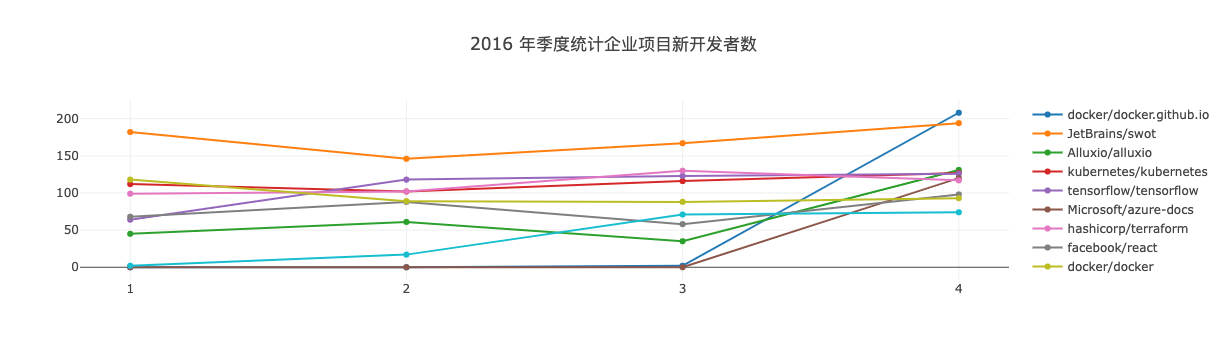

In [20]:
var startYear = 2016, startMonth = 1, endYear = 2016, endMonth = 12, x = [];
for (let y = 1; y <= 4; y++) x.push(`${y}`);
openDigger.metric.chaoss.chaossNewContributors({  labelIntersect: ['Company'], startYear, startMonth, endYear, endMonth, order:'DESC', groupTimeRange: 'quarter', limit: 10, options: { by: 'change request' }}).then(data => {
    console.log(`${data[0].name} 在 2016 年第四季度的新开发者包含：${data[0].detail[3]}。`);
    openDigger.render.plotly(data.filter(row => row.name != 'Others').map(row => {
        return {
            x,
            y: row.new_contributors,
            mode: 'scatter',
            name: row.name
        };
    }), {title: `2016 年季度统计企业项目新开发者数`, xaxis: {type: 'category'}});
});

或可以配置使用 commit 记录来计算。

Microsoft/azure-docs 在 2016 年第四季度的新开发者包含：rverschuur,Sreedhar Pelluru,seguler,Liza Poggemeyer,Kelly Gremban,rakshitatandon,Mark Paluch,Vitaliy Konev,Alejandro Guerrero Gonzalez,Abhishek Narain,Nicholas Romyn,Gaurav Mantri,tfitzmac,Olivier Martin,Goran Condric,soeren-lubitz,Jeff Stokes,arramac,Jim Dial,a-tan,Robin Shahan,Ryan Wike,Richard Rundle,Samuel Chan,Blomart Cédric,Dan Rediske,Alex Oancea,Pirmin Felber,Tom FitzMacken,justintian,Devendra Tiwari,Mahesh V S,Kris Crider,TomArcher,misteed-msft,Peter Taylor,MikeRayMSFT,Tim Lovell-Smith,randycampbell,Kristine Toliver (Aquent LLC),Chris Livermore,Takekazu Omi,ShawnJackson,RossAdams,kriscrider,Simon Rolfe,itechedit,bb-froggy,wesmc7777,Michael Hauss,Katie Cumming,Ying Hua,vkonev,Jakob Gottlieb Svendsen,Jarrett Renshaw,mattglabelle,Kevin Williamson,Iain Shepherd,Yufei Huang,rotycenh,Bruce Johnston,Allen Clark (VS),symphonyeyc,vitorfariatomaz,Elizabeth Oldag,Alessandro Segala,Adrian Hall,yongjun tian,Scott Weldon,Guilherme Caminha,Nitin Mehro

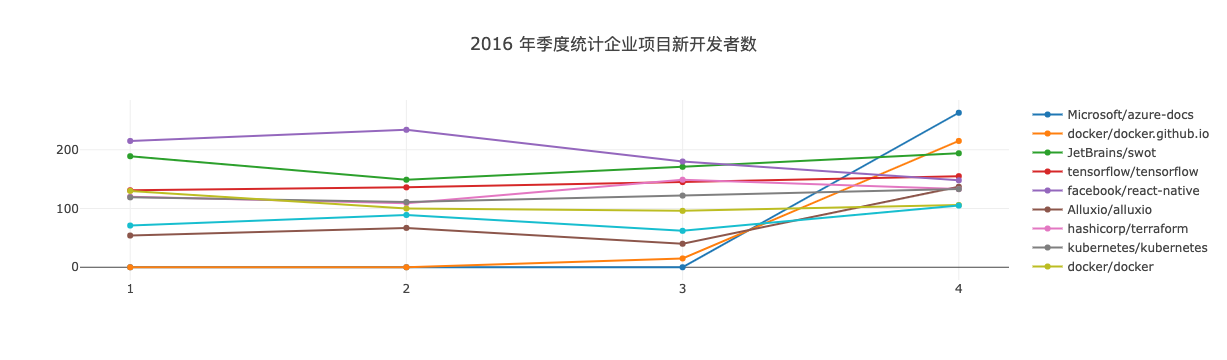

In [21]:
var startYear = 2016, startMonth = 1, endYear = 2016, endMonth = 12, x = [];
for (let y = 1; y <= 4; y++) x.push(`${y}`);
openDigger.metric.chaoss.chaossNewContributors({  labelIntersect: ['Company'], startYear, startMonth, endYear, endMonth, order:'DESC', groupTimeRange: 'quarter', limit: 10, options: { by: 'commit' }}).then(data => {
    console.log(`${data[0].name} 在 2016 年第四季度的新开发者包含：${data[0].detail[3]}。`);
    openDigger.render.plotly(data.filter(row => row.name != 'Others').map(row => {
        return {
            x,
            y: row.new_contributors,
            mode: 'scatter',
            name: row.name
        };
    }), {title: `2016 年季度统计企业项目新开发者数`, xaxis: {type: 'category'}});
});

### Driver

OpenDigger 同样提供了可以直接与数据库通信的接口，可以直接使用 SQL 请求进行定制化的分析。

#### Clickhouse

Clickhouse 接口用于直接与 2015 至今的 GitHub 全量事件日志数据进行交互。

可以通过 `openDigger.driver.clickhouse.query(sql: string)` 函数来请求数据。

下面的示例是使用 Clickhouse 数据查询 2015 到 2021 年之间每年日志数量的方法。

[
  { count: '206267684', year: 2015 },
  { count: '311725416', year: 2016 },
  { count: '408625079', year: 2017 },
  { count: '474568776', year: 2018 },
  { count: '599127116', year: 2019 },
  { count: '855440472', year: 2020 },
  { count: '977130719', year: 2021 }
]


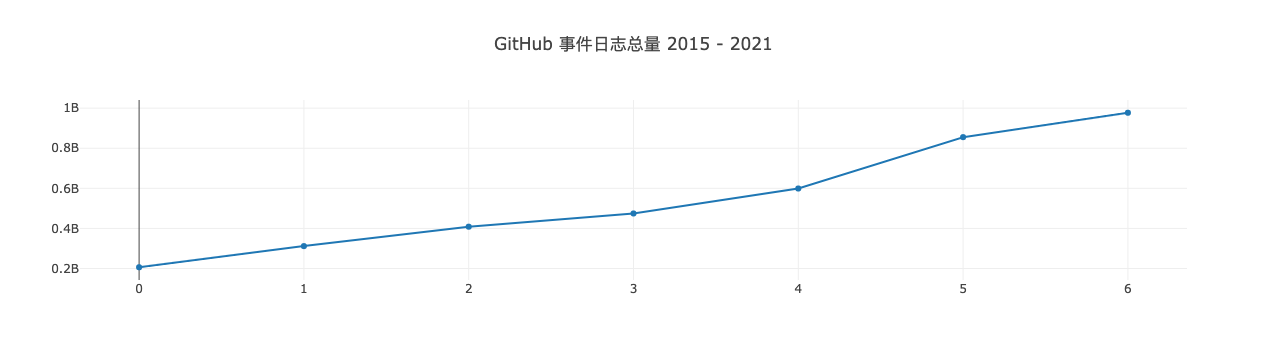

In [5]:
var startYear = 2015, endYear = 2021;
var years = [];
for (var y = startYear; y <= endYear; y++) years.push(y);
openDigger.driver.clickhouse.query(`SELECT COUNT() AS count, toYear(created_at) AS year FROM gh_events WHERE year >= ${startYear} AND year <= ${endYear} GROUP BY year ORDER BY year`, { format: 'JSONEachRow' } ).then(data => {
    console.log(data);  // 直接打印数据
    openDigger.render.plotly([
        {y: data.map(d => d.count), mode: 'lines+markers', name: 'log_count'}
    ], {title: `GitHub 事件日志总量 ${startYear} - ${endYear}`});  // 使用 Plotly 绘图
});

#### Neo4j

Neo4j 接口用于图数据交互，图数据中的活跃度与 OpenRank 按月聚合计算，时间区间与 Clickhouse 数据保持一致。

可通过 `openDigger.driver.neo4j.query(sql: string)` 函数来请求数据。

下面的示例是使用 Neo4j 数据查询 alibaba 组织下 2021 年每月 OpenRank 总值的方法。

[
  {
    open_rank_20211: 1378.2449947086238,
    open_rank_20212: 1205.9290687883301,
    open_rank_20213: 1198.0659094044643,
    open_rank_20214: 1309.535816358224,
    open_rank_20215: 1217.7917311759222,
    open_rank_20216: 1308.4420165438437,
    open_rank_20217: 1397.4789267862357,
    open_rank_20218: 1341.1264339608747,
    open_rank_20219: 1290.6398701659832,
    open_rank_202110: 869.2497420097089,
    open_rank_202111: 1147.450127156078,
    open_rank_202112: 1340.6250216589958
  }
]


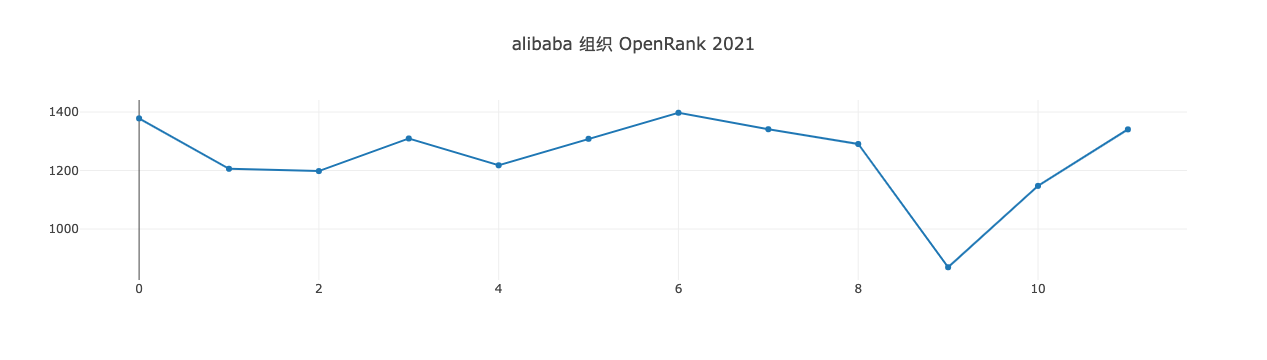

In [11]:
var startMonth = 1, endMonth = 12, org = 'alibaba';
var monthQuery = [];
for (var m = startMonth; m <= endMonth; m++) monthQuery.push(`SUM(COALESCE(r.open_rank_2021${m}, 0.0)) AS open_rank_2021${m}`);
openDigger.driver.neo4j.query(`MATCH (r:Repo) WHERE r.org_login='${org}' RETURN ${monthQuery.join(',')}`).then(data => {
    console.log(data);  // log to console
    openDigger.render.plotly([
        {y: Object.values(data[0]), mode: 'lines+markers', name: 'open_rank'}
    ], {title: `${org} 组织 OpenRank 2021`});  // show the result as image
});